In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import torch
from torchvision.utils import save_image
import torch.nn.functional as F
import glob
import PIL
from PIL import Image
from torch.utils import data as D
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import random
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
from __future__ import print_function, division, absolute_import
import math
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from torch.nn import init
from torch.autograd import Variable
from sklearn.metrics import classification_report, f1_score

In [4]:
X_train = np.load("/content/drive/Shared drives/EECS545/unzipped_files/malaria/X_train.npy")
y_train = np.load("/content/drive/Shared drives/EECS545/unzipped_files/malaria/y_train.npy")
print(X_train.shape)
print(y_train.shape)

(80113, 32, 32, 3)
(80113, 1)


In [5]:
X_test = np.load("/content/drive/Shared drives/EECS545/unzipped_files/malaria/X_test.npy")
y_test = np.load("/content/drive/Shared drives/EECS545/unzipped_files/malaria/y_test.npy")
print(X_test.shape)
print(y_test.shape)

(5922, 32, 32, 3)
(5922, 1)


## **Model**


In [0]:
__all__ = ['AlexNet', 'alexnet']


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}


class AlexNet(nn.Module):

    def __init__(self, num_classes=7):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def alexnet(pretrained=False, progress=True, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [8]:
batch_size = 32
validation_ratio = 0.1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


batch_size = 16
validation_ratio = 0.1
initial_lr = 0.005

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [0]:
class malaria_dataset(Dataset):
  def __init__(self, X, y, transform=None):
    self.images = X
    self.labels = y
    self.transform = transform

  def __getitem__(self, index):
    img = self.images[index]
    label = self.labels[index]

    if self.transform is not None:
      img = self.transform(img)

    return img, label

  def __len__(self):
    return len(self.images)

In [10]:
split_point = int(np.floor(len(X_train) * validation_ratio))
indices = np.arange(len(X_train))
np.random.seed(3)
np.random.shuffle(indices)
train_idx, valid_idx = indices[split_point:], indices[:split_point]

train_img = X_train[train_idx]
train_label = y_train[train_idx]
valid_img = X_train[valid_idx]
valid_label = y_train[valid_idx]
test_img = X_test
test_label = y_test

print("Train dataset")
print(train_img.shape)
print(train_label.shape)
for i in range(7):
  cur_idx = np.argwhere(train_label == i)
  print("{} label: {}".format(i, len(cur_idx)))

print("Valid dataset")
print(valid_img.shape)
print(valid_label.shape)
for i in range(7):
  cur_idx = np.argwhere(valid_label == i)
  print("{} label: {}".format(i, len(cur_idx)))

print("Test dataset")
print(test_img.shape)
print(test_label.shape)
for i in range(7):
  cur_idx = np.argwhere(test_label == i)
  print("{} label: {}".format(i, len(cur_idx)))
malaria_train = malaria_dataset(train_img, train_label,
                               transform=transforms.Compose([transforms.ToTensor()]))
malaria_valid = malaria_dataset(valid_img, valid_label,
                               transform=transforms.Compose([transforms.ToTensor()]))
malaria_test = malaria_dataset(test_img, test_label,
                               transform=transforms.Compose([transforms.ToTensor()]))

Train dataset
(72102, 32, 32, 3)
(72102, 1)
0 label: 69690
1 label: 1326
2 label: 160
3 label: 397
4 label: 314
5 label: 87
6 label: 128
Valid dataset
(8011, 32, 32, 3)
(8011, 1)
0 label: 7730
1 label: 147
2 label: 19
3 label: 44
4 label: 39
5 label: 16
6 label: 16
Test dataset
(5922, 32, 32, 3)
(5922, 1)
0 label: 5614
1 label: 111
2 label: 11
3 label: 5
4 label: 169
5 label: 0
6 label: 12


#cross entropy loss

F1 Score Lr = 0.0001 Crossentropy Adam

In [0]:
initial_lr = 0.0001
num_epochs = 15
batch_size = 32
Xception_model = alexnet()
Xception_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Xception_model.parameters(), lr=initial_lr)

train_loader = torch.utils.data.DataLoader(
    malaria_train, batch_size=batch_size
)
valid_loader = torch.utils.data.DataLoader(
    malaria_valid, batch_size=batch_size
)
test_loader = torch.utils.data.DataLoader(
    malaria_test, batch_size=batch_size, shuffle=False
)

loss_history = []
train_acc = []
train_f1_score = []
val_acc = []
val_f1_score = []
for epoch in range(num_epochs):
    print("epoch {}".format(epoch+1))

    if epoch == 0:
        lr = initial_lr
    elif epoch % 2 == 0 and epoch != 0:
        lr *= 0.94
        optimizer = optim.Adam(Xception_model.parameters(), lr=initial_lr)
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # Data augmentation
        # Horizontal Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(2)
        # Vertical Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(3)
        # 90 rotation
        if torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3)
        # or 270 rotation
        elif torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3).flip(3)
        labels = labels.view(-1)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = Xception_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        show_period = 250
        if i % show_period == show_period-1:    # print every "show_period" mini-batches
            print('[%d, %5d] loss: %.7f' %
                  (epoch + 1, i + 1, running_loss / show_period))
            loss_history.append(running_loss)
            running_loss = 0.0
        
    #validation part
    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Training accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    train_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Training f1 score = {0:.3f}".format(f1))
    train_f1_score.append(f1)

    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(valid_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Validation accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    val_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Valid f1 score = {0:.3f}".format(f1))
    val_f1_score.append(f1)

print('Finished Training')

epoch 1
[1,   250] loss: 0.2160204
[1,   500] loss: 0.1444512
[1,   750] loss: 0.1261772
[1,  1000] loss: 0.0926432
[1,  1250] loss: 0.0849609
[1,  1500] loss: 0.0702183
[1,  1750] loss: 0.0755627
[1,  2000] loss: 0.0701242
[1,  2250] loss: 0.0622603
Training accuracy = 98.343%
0 label: Total=69690.0, correct=69637.0, acc=0.9992394891663079
1 label: Total=1326.0, correct=1025.0, acc=0.773001508295626
2 label: Total=160.0, correct=68.0, acc=0.425
3 label: Total=397.0, correct=109.0, acc=0.27455919395465994
4 label: Total=314.0, correct=0.0, acc=0.0
5 label: Total=87.0, correct=68.0, acc=0.7816091954022989
6 label: Total=128.0, correct=0.0, acc=0.0
Training f1 score = 0.451


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Validation accuracy = 98.265%
0 label: Total=7730.0, correct=7721.0, acc=0.9988357050452782
1 label: Total=147.0, correct=123.0, acc=0.8367346938775511
2 label: Total=19.0, correct=10.0, acc=0.5263157894736842
3 label: Total=44.0, correct=10.0, acc=0.22727272727272727
4 label: Total=39.0, correct=0.0, acc=0.0
5 label: Total=16.0, correct=8.0, acc=0.5
6 label: Total=16.0, correct=0.0, acc=0.0
Valid f1 score = 0.434
epoch 2
[2,   250] loss: 0.0635249
[2,   500] loss: 0.0711784
[2,   750] loss: 0.0670293
[2,  1000] loss: 0.0561564
[2,  1250] loss: 0.0610720
[2,  1500] loss: 0.0521372
[2,  1750] loss: 0.0601391
[2,  2000] loss: 0.0544145
[2,  2250] loss: 0.0559925
Training accuracy = 98.307%
0 label: Total=69690.0, correct=69668.0, acc=0.9996843162577127
1 label: Total=1326.0, correct=1007.0, acc=0.7594268476621417
2 label: Total=160.0, correct=43.0, acc=0.26875
3 label: Total=397.0, correct=94.0, acc=0.2367758186397985
4 label: Total=314.0, correct=0.0, acc=0.0
5 label: Total=87.0, correc

In [0]:
# test part
correct = 0
total = 0
each_correct = np.zeros(7)
each_total = np.zeros(7)
total_predicted = None
total_labels = None
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    labels = labels.view(-1)
    outputs = Xception_model(inputs)
    
    _, predicted = torch.max(outputs.data, 1)
    if total_predicted is None:
      total_predicted = predicted
      total_labels = labels
    else:
      total_predicted = torch.cat((total_predicted, predicted), axis=0)
      total_labels = torch.cat((total_labels, labels), axis=0)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    for i in range(7):
      cur_idx = (labels == i).nonzero()
      cur_label = labels[cur_idx]
      cur_predicted = predicted[cur_idx]
      each_total[i] += cur_label.size(0)
      each_correct[i] += (cur_predicted == cur_label).sum().item()
print("Test accuracy = {0:.3f}%".format(correct / total * 100))
for i in range(7):
  print("{} label: Total={}, correct={}, acc={}".format(i,
                                                        each_total[i],
                                                        each_correct[i],
                                                        each_correct[i]/each_total[i]))
f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
print("Test f1 score = {0:.3f}".format(f1))
val_f1_score.append(f1)

Test accuracy = 75.743%
0 label: Total=195.0, correct=153.0, acc=0.7846153846153846
1 label: Total=3.0, correct=0.0, acc=0.0
2 label: Total=0.0, correct=0.0, acc=nan
3 label: Total=0.0, correct=0.0, acc=nan
4 label: Total=4.0, correct=0.0, acc=0.0
5 label: Total=0.0, correct=0.0, acc=nan
6 label: Total=0.0, correct=0.0, acc=nan
Test f1 score = 0.219


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


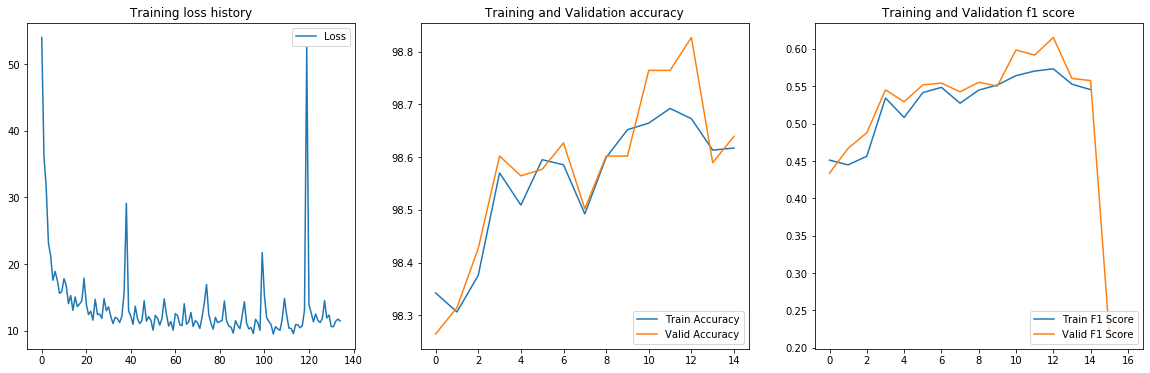

In [0]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].plot(loss_history, label='Loss')
axs[0].title.set_text("Training loss history")
axs[0].legend(loc="upper right")
axs[1].plot(train_acc, label='Train Accuracy')
axs[1].plot(val_acc, label='Valid Accuracy')
axs[1].title.set_text("Training and Validation accuracy")
axs[1].legend(loc="lower right")
axs[2].plot(train_f1_score, label='Train F1 Score')
axs[2].plot(val_f1_score, label='Valid F1 Score')
axs[2].title.set_text("Training and Validation f1 score")
axs[2].legend(loc="lower right")

F1 Score Lr = 0.0001 Crossentropy SGD

In [0]:
initial_lr = 0.0001
num_epochs = 15
batch_size = 32
Xception_model = alexnet()
Xception_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Xception_model.parameters(), lr=initial_lr, momentum=0.9)

train_loader = torch.utils.data.DataLoader(
    malaria_train, batch_size=batch_size
)
valid_loader = torch.utils.data.DataLoader(
    malaria_valid, batch_size=batch_size
)
test_loader = torch.utils.data.DataLoader(
    malaria_test, batch_size=batch_size, shuffle=False
)

loss_history = []
train_acc = []
train_f1_score = []
val_acc = []
val_f1_score = []
for epoch in range(num_epochs):
    print("epoch {}".format(epoch+1))

    if epoch == 0:
        lr = initial_lr
    elif epoch % 2 == 0 and epoch != 0:
        lr *= 0.94
        optimizer = optim.Adam(Xception_model.parameters(), lr=initial_lr)
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # Data augmentation
        # Horizontal Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(2)
        # Vertical Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(3)
        # 90 rotation
        if torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3)
        # or 270 rotation
        elif torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3).flip(3)
        labels = labels.view(-1)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = Xception_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        show_period = 250
        if i % show_period == show_period-1:    # print every "show_period" mini-batches
            print('[%d, %5d] loss: %.7f' %
                  (epoch + 1, i + 1, running_loss / show_period))
            loss_history.append(running_loss)
            running_loss = 0.0
        
    #validation part
    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Training accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    train_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Training f1 score = {0:.3f}".format(f1))
    train_f1_score.append(f1)

    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(valid_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Validation accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    val_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Valid f1 score = {0:.3f}".format(f1))
    val_f1_score.append(f1)

print('Finished Training')

epoch 1
[1,   250] loss: 1.8117374
[1,   500] loss: 1.5226494
[1,   750] loss: 0.7120913
[1,  1000] loss: 0.2175946
[1,  1250] loss: 0.2047038
[1,  1500] loss: 0.1963931
[1,  1750] loss: 0.2117748
[1,  2000] loss: 0.2074750
[1,  2250] loss: 0.1913103
Training accuracy = 96.655%
0 label: Total=69690.0, correct=69690.0, acc=1.0
1 label: Total=1326.0, correct=0.0, acc=0.0
2 label: Total=160.0, correct=0.0, acc=0.0
3 label: Total=397.0, correct=0.0, acc=0.0
4 label: Total=314.0, correct=0.0, acc=0.0
5 label: Total=87.0, correct=0.0, acc=0.0
6 label: Total=128.0, correct=0.0, acc=0.0
Training f1 score = 0.140


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Validation accuracy = 96.492%
0 label: Total=7730.0, correct=7730.0, acc=1.0
1 label: Total=147.0, correct=0.0, acc=0.0
2 label: Total=19.0, correct=0.0, acc=0.0
3 label: Total=44.0, correct=0.0, acc=0.0
4 label: Total=39.0, correct=0.0, acc=0.0
5 label: Total=16.0, correct=0.0, acc=0.0
6 label: Total=16.0, correct=0.0, acc=0.0
Valid f1 score = 0.140
epoch 2
[2,   250] loss: 0.1961942
[2,   500] loss: 0.2189434
[2,   750] loss: 0.1984601
[2,  1000] loss: 0.2051679
[2,  1250] loss: 0.1966908
[2,  1500] loss: 0.1886148
[2,  1750] loss: 0.2061071
[2,  2000] loss: 0.2029735
[2,  2250] loss: 0.1898425
Training accuracy = 96.655%
0 label: Total=69690.0, correct=69690.0, acc=1.0
1 label: Total=1326.0, correct=0.0, acc=0.0
2 label: Total=160.0, correct=0.0, acc=0.0
3 label: Total=397.0, correct=0.0, acc=0.0
4 label: Total=314.0, correct=0.0, acc=0.0
5 label: Total=87.0, correct=0.0, acc=0.0
6 label: Total=128.0, correct=0.0, acc=0.0
Training f1 score = 0.140
Validation accuracy = 96.492%
0 lab

In [0]:
# test part
correct = 0
total = 0
each_correct = np.zeros(7)
each_total = np.zeros(7)
total_predicted = None
total_labels = None
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    labels = labels.view(-1)
    outputs = Xception_model(inputs)
    
    _, predicted = torch.max(outputs.data, 1)
    if total_predicted is None:
      total_predicted = predicted
      total_labels = labels
    else:
      total_predicted = torch.cat((total_predicted, predicted), axis=0)
      total_labels = torch.cat((total_labels, labels), axis=0)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    for i in range(7):
      cur_idx = (labels == i).nonzero()
      cur_label = labels[cur_idx]
      cur_predicted = predicted[cur_idx]
      each_total[i] += cur_label.size(0)
      each_correct[i] += (cur_predicted == cur_label).sum().item()
print("Test accuracy = {0:.3f}%".format(correct / total * 100))
for i in range(7):
  print("{} label: Total={}, correct={}, acc={}".format(i,
                                                        each_total[i],
                                                        each_correct[i],
                                                        each_correct[i]/each_total[i]))
f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
print("Test f1 score = {0:.3f}".format(f1))
val_f1_score.append(f1)

Test accuracy = 96.535%
0 label: Total=195.0, correct=195.0, acc=1.0
1 label: Total=3.0, correct=0.0, acc=0.0
2 label: Total=0.0, correct=0.0, acc=nan
3 label: Total=0.0, correct=0.0, acc=nan
4 label: Total=4.0, correct=0.0, acc=0.0
5 label: Total=0.0, correct=0.0, acc=nan
6 label: Total=0.0, correct=0.0, acc=nan
Test f1 score = 0.327


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


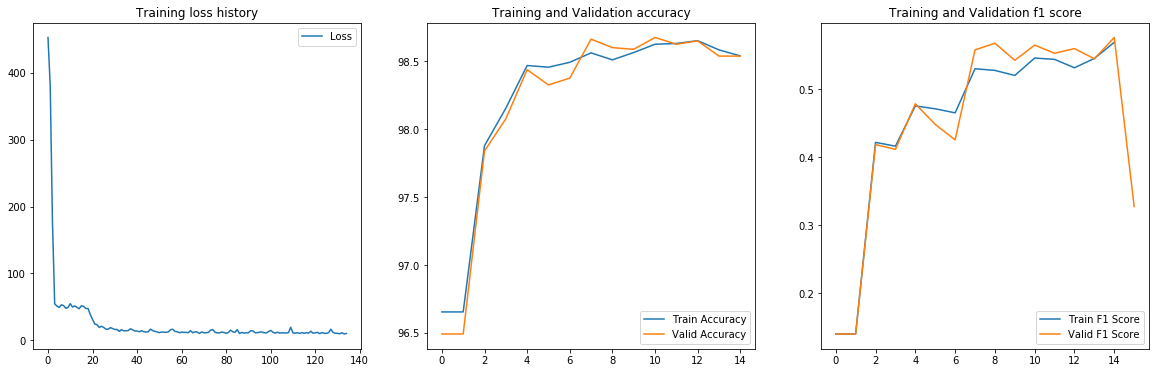

In [0]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].plot(loss_history, label='Loss')
axs[0].title.set_text("Training loss history")
axs[0].legend(loc="upper right")
axs[1].plot(train_acc, label='Train Accuracy')
axs[1].plot(val_acc, label='Valid Accuracy')
axs[1].title.set_text("Training and Validation accuracy")
axs[1].legend(loc="lower right")
axs[2].plot(train_f1_score, label='Train F1 Score')
axs[2].plot(val_f1_score, label='Valid F1 Score')
axs[2].title.set_text("Training and Validation f1 score")
axs[2].legend(loc="lower right")

#the best model! with lr 0.1 1e-6

the Best Model, SGD CrossEntropy,lr= 0.0001
we use different Lr in this case 1e-6 & 0.1


In [12]:
initial_lr = 0.1
num_epochs = 15
batch_size = 32
Xception_model = alexnet()
Xception_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Xception_model.parameters(), lr=initial_lr, momentum=0.9)

train_loader = torch.utils.data.DataLoader(
    malaria_train, batch_size=batch_size
)
valid_loader = torch.utils.data.DataLoader(
    malaria_valid, batch_size=batch_size
)
test_loader = torch.utils.data.DataLoader(
    malaria_test, batch_size=batch_size, shuffle=False
)

loss_history = []
train_acc = []
train_f1_score = []
val_acc = []
val_f1_score = []
for epoch in range(num_epochs):
    print("epoch {}".format(epoch+1))

    if epoch == 0:
        lr = initial_lr
    elif epoch % 2 == 0 and epoch != 0:
        lr *= 0.94
        optimizer = optim.Adam(Xception_model.parameters(), lr=initial_lr)
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # Data augmentation
        # Horizontal Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(2)
        # Vertical Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(3)
        # 90 rotation
        if torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3)
        # or 270 rotation
        elif torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3).flip(3)
        labels = labels.view(-1)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = Xception_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        show_period = 250
        if i % show_period == show_period-1:    # print every "show_period" mini-batches
            print('[%d, %5d] loss: %.7f' %
                  (epoch + 1, i + 1, running_loss / show_period))
            loss_history.append(running_loss)
            running_loss = 0.0
        
    #validation part
    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Training accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    train_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Training f1 score = {0:.3f}".format(f1))
    train_f1_score.append(f1)

    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(valid_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Validation accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    val_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Valid f1 score = {0:.3f}".format(f1))
    val_f1_score.append(f1)

print('Finished Training')

epoch 1
[1,   250] loss: 0.2156970
[1,   500] loss: 0.2113787
[1,   750] loss: 0.1915308
[1,  1000] loss: 0.1990092
[1,  1250] loss: 0.1898461
[1,  1500] loss: 0.1817211
[1,  1750] loss: 0.1978794
[1,  2000] loss: 0.1985066
[1,  2250] loss: 0.1825335
Training accuracy = 96.655%
0 label: Total=69690.0, correct=69690.0, acc=1.0
1 label: Total=1326.0, correct=0.0, acc=0.0
2 label: Total=160.0, correct=0.0, acc=0.0
3 label: Total=397.0, correct=0.0, acc=0.0
4 label: Total=314.0, correct=0.0, acc=0.0
5 label: Total=87.0, correct=0.0, acc=0.0
6 label: Total=128.0, correct=0.0, acc=0.0
Training f1 score = 0.140


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Validation accuracy = 96.492%
0 label: Total=7730.0, correct=7730.0, acc=1.0
1 label: Total=147.0, correct=0.0, acc=0.0
2 label: Total=19.0, correct=0.0, acc=0.0
3 label: Total=44.0, correct=0.0, acc=0.0
4 label: Total=39.0, correct=0.0, acc=0.0
5 label: Total=16.0, correct=0.0, acc=0.0
6 label: Total=16.0, correct=0.0, acc=0.0
Valid f1 score = 0.140
epoch 2
[2,   250] loss: 0.1850486
[2,   500] loss: 0.2103353
[2,   750] loss: 0.1909863
[2,  1000] loss: 0.1985758
[2,  1250] loss: 0.1892438
[2,  1500] loss: 0.1813833
[2,  1750] loss: 0.1974564
[2,  2000] loss: 0.1979132
[2,  2250] loss: 0.1822743
Training accuracy = 96.655%
0 label: Total=69690.0, correct=69690.0, acc=1.0
1 label: Total=1326.0, correct=0.0, acc=0.0
2 label: Total=160.0, correct=0.0, acc=0.0
3 label: Total=397.0, correct=0.0, acc=0.0
4 label: Total=314.0, correct=0.0, acc=0.0
5 label: Total=87.0, correct=0.0, acc=0.0
6 label: Total=128.0, correct=0.0, acc=0.0
Training f1 score = 0.140
Validation accuracy = 96.492%
0 lab

In [13]:
# test part
correct = 0
total = 0
each_correct = np.zeros(7)
each_total = np.zeros(7)
total_predicted = None
total_labels = None
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    labels = labels.view(-1)
    outputs = Xception_model(inputs)
    
    _, predicted = torch.max(outputs.data, 1)
    if total_predicted is None:
      total_predicted = predicted
      total_labels = labels
    else:
      total_predicted = torch.cat((total_predicted, predicted), axis=0)
      total_labels = torch.cat((total_labels, labels), axis=0)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    for i in range(7):
      cur_idx = (labels == i).nonzero()
      cur_label = labels[cur_idx]
      cur_predicted = predicted[cur_idx]
      each_total[i] += cur_label.size(0)
      each_correct[i] += (cur_predicted == cur_label).sum().item()
print("Test accuracy = {0:.3f}%".format(correct / total * 100))
for i in range(7):
  print("{} label: Total={}, correct={}, acc={}".format(i,
                                                        each_total[i],
                                                        each_correct[i],
                                                        each_correct[i]/each_total[i]))
f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
print("Test f1 score = {0:.3f}".format(f1))
val_f1_score.append(f1)

Test accuracy = 94.799%
0 label: Total=5614.0, correct=5614.0, acc=1.0
1 label: Total=111.0, correct=0.0, acc=0.0
2 label: Total=11.0, correct=0.0, acc=0.0
3 label: Total=5.0, correct=0.0, acc=0.0
4 label: Total=169.0, correct=0.0, acc=0.0
5 label: Total=0.0, correct=0.0, acc=nan
6 label: Total=12.0, correct=0.0, acc=0.0
Test f1 score = 0.162


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


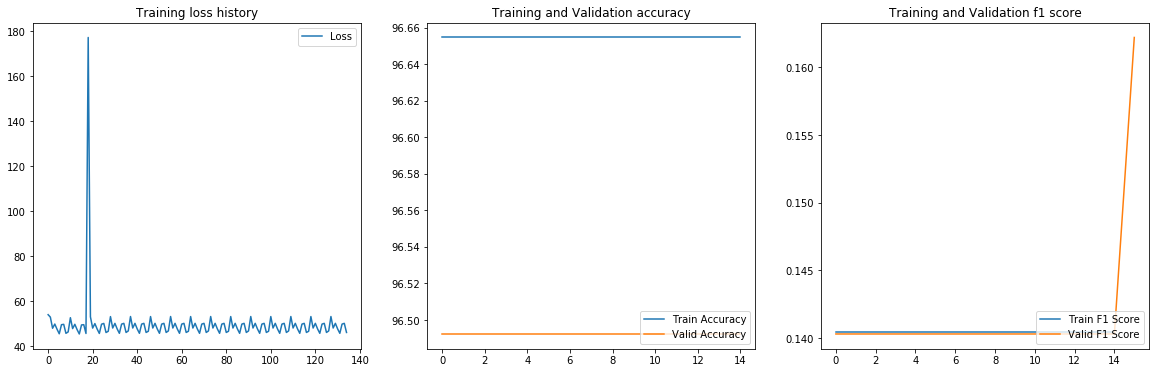

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].plot(loss_history, label='Loss')
axs[0].title.set_text("Training loss history")
axs[0].legend(loc="upper right")
axs[1].plot(train_acc, label='Train Accuracy')
axs[1].plot(val_acc, label='Valid Accuracy')
axs[1].title.set_text("Training and Validation accuracy")
axs[1].legend(loc="lower right")
axs[2].plot(train_f1_score, label='Train F1 Score')
axs[2].plot(val_f1_score, label='Valid F1 Score')
axs[2].title.set_text("Training and Validation f1 score")
axs[2].legend(loc="lower right")

In [0]:
initial_lr = 0.0001
num_epochs = 15
batch_size = 32
Xception_model = alexnet()
Xception_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Xception_model.parameters(), lr=initial_lr, momentum=0.9)

train_loader = torch.utils.data.DataLoader(
    malaria_train, batch_size=batch_size
)
valid_loader = torch.utils.data.DataLoader(
    malaria_valid, batch_size=batch_size
)
test_loader = torch.utils.data.DataLoader(
    malaria_test, batch_size=batch_size, shuffle=False
)

loss_history = []
train_acc = []
train_f1_score = []
val_acc = []
val_f1_score = []
for epoch in range(num_epochs):
    print("epoch {}".format(epoch+1))

    if epoch == 0:
        lr = initial_lr
    elif epoch % 2 == 0 and epoch != 0:
        lr *= 0.94
        optimizer = optim.Adam(Xception_model.parameters(), lr=initial_lr)
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # Data augmentation
        # Horizontal Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(2)
        # Vertical Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(3)
        # 90 rotation
        if torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3)
        # or 270 rotation
        elif torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3).flip(3)
        labels = labels.view(-1)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = Xception_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        show_period = 250
        if i % show_period == show_period-1:    # print every "show_period" mini-batches
            print('[%d, %5d] loss: %.7f' %
                  (epoch + 1, i + 1, running_loss / show_period))
            loss_history.append(running_loss)
            running_loss = 0.0
        
    #validation part
    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Training accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    train_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Training f1 score = {0:.3f}".format(f1))
    train_f1_score.append(f1)

    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(valid_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Validation accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    val_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Valid f1 score = {0:.3f}".format(f1))
    val_f1_score.append(f1)

print('Finished Training')

In [0]:
# test part
correct = 0
total = 0
each_correct = np.zeros(7)
each_total = np.zeros(7)
total_predicted = None
total_labels = None
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    labels = labels.view(-1)
    outputs = Xception_model(inputs)
    
    _, predicted = torch.max(outputs.data, 1)
    if total_predicted is None:
      total_predicted = predicted
      total_labels = labels
    else:
      total_predicted = torch.cat((total_predicted, predicted), axis=0)
      total_labels = torch.cat((total_labels, labels), axis=0)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    for i in range(7):
      cur_idx = (labels == i).nonzero()
      cur_label = labels[cur_idx]
      cur_predicted = predicted[cur_idx]
      each_total[i] += cur_label.size(0)
      each_correct[i] += (cur_predicted == cur_label).sum().item()
print("Test accuracy = {0:.3f}%".format(correct / total * 100))
for i in range(7):
  print("{} label: Total={}, correct={}, acc={}".format(i,
                                                        each_total[i],
                                                        each_correct[i],
                                                        each_correct[i]/each_total[i]))
f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
print("Test f1 score = {0:.3f}".format(f1))
val_f1_score.append(f1)

In [0]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].plot(loss_history, label='Loss')
axs[0].title.set_text("Training loss history")
axs[0].legend(loc="upper right")
axs[1].plot(train_acc, label='Train Accuracy')
axs[1].plot(val_acc, label='Valid Accuracy')
axs[1].title.set_text("Training and Validation accuracy")
axs[1].legend(loc="lower right")
axs[2].plot(train_f1_score, label='Train F1 Score')
axs[2].plot(val_f1_score, label='Valid F1 Score')
axs[2].title.set_text("Training and Validation f1 score")
axs[2].legend(loc="lower right")

#Focal Loss

Adam Focal loss Lr = 0.0001

In [0]:
def one_hot_embedding(labels, num_classes):
    '''Embedding labels to one-hot form.
    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.
    Returns:
      (tensor) encoded labels, sized [N,#classes].
    '''
    y = torch.eye(num_classes)  # [D,D]
    return y[labels]            # [N,D]


class FocalLoss(nn.Module):
    def __init__(self, num_classes=7):
        super(FocalLoss, self).__init__()
        self.num_classes = num_classes

    def focal_loss(self, x, y):
        '''Focal loss.
        Args:
          x: (tensor) sized [N,D].
          y: (tensor) sized [N,].
        Return:
          (tensor) focal loss.
        '''
        alpha = 0.25
        gamma = 2

        t = one_hot_embedding(y.data.cpu(), 1+self.num_classes)  # [N,21]
        t = t[:,1:]  # exclude background
        t = Variable(t).cuda()  # [N,20]

        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)         # pt = p if t > 0 else 1-p
        w = alpha*t + (1-alpha)*(1-t)  # w = alpha if t > 0 else 1-alpha
        w = w * (1-pt).pow(gamma)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)

    def focal_loss_alt(self, x, y):
        '''Focal loss alternative.
        Args:
          x: (tensor) sized [N,D].
          y: (tensor) sized [N,].
        Return:
          (tensor) focal loss.
        '''
        alpha = 0.25
        eps = 1e-8

        t = one_hot_embedding(y.data.cpu(), self.num_classes)
        t = Variable(t).cuda()

        xt = x*(2*t-1)  # xt = x if t > 0 else -x
        pt = (2*xt+1).sigmoid()

        w = alpha*t + (1-alpha)*(1-t)
        loss = -w*pt.log() / 2
        return loss.sum()

    def forward(self, outputs, labels):
        loss = self.focal_loss_alt(outputs, labels)
        return loss

In [0]:
initial_lr = 0.0001
batch_size = 32
num_epochs = 15

Xception_model = alexnet()
Xception_model.to(device)
criterion = FocalLoss(num_classes=7)
optimizer = optim.Adam(Xception_model.parameters(), lr=initial_lr)

train_loader = torch.utils.data.DataLoader(
    malaria_train, batch_size=batch_size
)
valid_loader = torch.utils.data.DataLoader(
    malaria_valid, batch_size=batch_size
)
test_loader = torch.utils.data.DataLoader(
    malaria_test, batch_size=batch_size, shuffle=False
)

loss_history = []
train_acc = []
val_acc = []
for epoch in range(num_epochs):
    print("epoch {}".format(epoch+1))

    if epoch == 0:
        lr = initial_lr
    elif epoch % 2 == 0 and epoch != 0:
        lr *= 0.94
        optimizer = optim.Adam(Xception_model.parameters(), lr=initial_lr)
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # Data augmentation
        # Horizontal Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(2)
        # Vertical Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(3)
        # 90 rotation
        if torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3)
        # or 270 rotation
        elif torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3).flip(3)

        labels = labels.view(-1)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = Xception_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        show_period = 250
        if i % show_period == show_period-1:    # print every "show_period" mini-batches
            print('[%d, %5d] loss: %.7f' %
                  (epoch + 1, i + 1, running_loss / show_period))
            loss_history.append(running_loss)
            running_loss = 0.0

    #validation part
    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Training accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    train_acc.append(correct / total * 100)
      
    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    for i, data in enumerate(valid_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Validation accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    val_acc.append(correct / total * 100)

print('Finished Training')

epoch 1
[1,   250] loss: 1.7444300
[1,   500] loss: 1.0587889
[1,   750] loss: 0.8827753
[1,  1000] loss: 0.6766061
[1,  1250] loss: 0.6303830
[1,  1500] loss: 0.5007056
[1,  1750] loss: 0.5628264
[1,  2000] loss: 0.5018656
[1,  2250] loss: 0.4475649
Training accuracy = 98.007%
0 label: Total=69690.0, correct=69580.0, acc=0.9984215812885636
1 label: Total=1326.0, correct=808.0, acc=0.6093514328808446
2 label: Total=160.0, correct=65.0, acc=0.40625
3 label: Total=397.0, correct=146.0, acc=0.3677581863979849
4 label: Total=314.0, correct=0.0, acc=0.0
5 label: Total=87.0, correct=66.0, acc=0.7586206896551724
6 label: Total=128.0, correct=0.0, acc=0.0
Validation accuracy = 97.990%
0 label: Total=7730.0, correct=7709.0, acc=0.9972833117723157
1 label: Total=147.0, correct=101.0, acc=0.6870748299319728
2 label: Total=19.0, correct=8.0, acc=0.42105263157894735
3 label: Total=44.0, correct=21.0, acc=0.4772727272727273
4 label: Total=39.0, correct=0.0, acc=0.0
5 label: Total=16.0, correct=11.0,

In [0]:
# test part
correct = 0
total = 0
each_correct = np.zeros(7)
each_total = np.zeros(7)
total_predicted = None
total_labels = None
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    labels = labels.view(-1)
    outputs = Xception_model(inputs)
    
    _, predicted = torch.max(outputs.data, 1)
    if total_predicted is None:
      total_predicted = predicted
      total_labels = labels
    else:
      total_predicted = torch.cat((total_predicted, predicted), axis=0)
      total_labels = torch.cat((total_labels, labels), axis=0)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    for i in range(7):
      cur_idx = (labels == i).nonzero()
      cur_label = labels[cur_idx]
      cur_predicted = predicted[cur_idx]
      each_total[i] += cur_label.size(0)
      each_correct[i] += (cur_predicted == cur_label).sum().item()
print("Test accuracy = {0:.3f}%".format(correct / total * 100))
for i in range(7):
  print("{} label: Total={}, correct={}, acc={}".format(i,
                                                        each_total[i],
                                                        each_correct[i],
                                                        each_correct[i]/each_total[i]))
f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
print("Test f1 score = {0:.3f}".format(f1))
val_f1_score.append(f1)

Test accuracy = 96.535%
0 label: Total=195.0, correct=195.0, acc=1.0
1 label: Total=3.0, correct=0.0, acc=0.0
2 label: Total=0.0, correct=0.0, acc=nan
3 label: Total=0.0, correct=0.0, acc=nan
4 label: Total=4.0, correct=0.0, acc=0.0
5 label: Total=0.0, correct=0.0, acc=nan
6 label: Total=0.0, correct=0.0, acc=nan
Test f1 score = 0.327


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


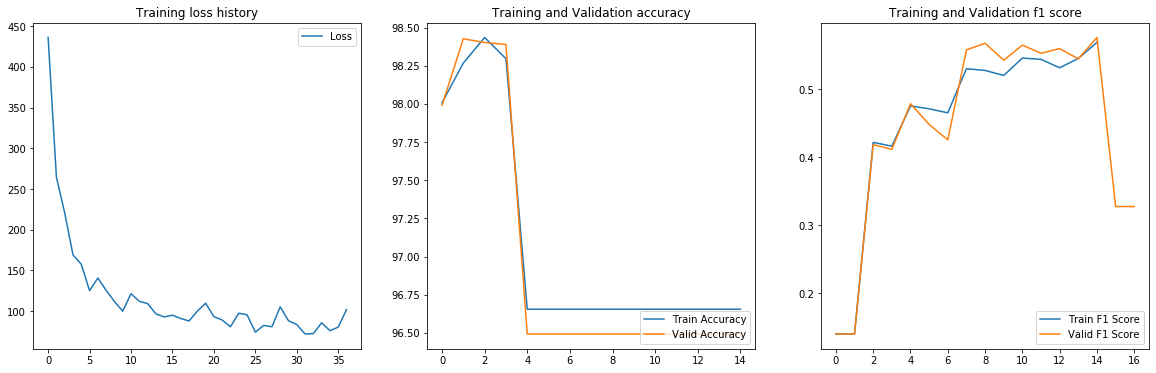

In [0]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].plot(loss_history, label='Loss')
axs[0].title.set_text("Training loss history")
axs[0].legend(loc="upper right")
axs[1].plot(train_acc, label='Train Accuracy')
axs[1].plot(val_acc, label='Valid Accuracy')
axs[1].title.set_text("Training and Validation accuracy")
axs[1].legend(loc="lower right")
axs[2].plot(train_f1_score, label='Train F1 Score')
axs[2].plot(val_f1_score, label='Valid F1 Score')
axs[2].title.set_text("Training and Validation f1 score")
axs[2].legend(loc="lower right")

Adam Focal loss Lr = 0.00001

In [0]:
initial_lr = 0.00001
batch_size = 32
num_epochs = 15

Xception_model = alexnet()
Xception_model.to(device)
criterion = FocalLoss(num_classes=7)
optimizer = optim.Adam(Xception_model.parameters(), lr=initial_lr)

train_loader = torch.utils.data.DataLoader(
    malaria_train, batch_size=batch_size
)
valid_loader = torch.utils.data.DataLoader(
    malaria_valid, batch_size=batch_size
)
test_loader = torch.utils.data.DataLoader(
    malaria_test, batch_size=batch_size, shuffle=False
)

loss_history = []
train_acc = []
val_acc = []
for epoch in range(num_epochs):
    print("epoch {}".format(epoch+1))

    if epoch == 0:
        lr = initial_lr
    elif epoch % 2 == 0 and epoch != 0:
        lr *= 0.94
        optimizer = optim.Adam(Xception_model.parameters(), lr=initial_lr)
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # Data augmentation
        # Horizontal Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(2)
        # Vertical Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(3)
        # 90 rotation
        if torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3)
        # or 270 rotation
        elif torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3).flip(3)

        labels = labels.view(-1)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = Xception_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        show_period = 250
        if i % show_period == show_period-1:    # print every "show_period" mini-batches
            print('[%d, %5d] loss: %.7f' %
                  (epoch + 1, i + 1, running_loss / show_period))
            loss_history.append(running_loss)
            running_loss = 0.0

    #validation part
    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Training accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    train_acc.append(correct / total * 100)
      
    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    for i, data in enumerate(valid_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Validation accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    val_acc.append(correct / total * 100)

print('Finished Training')

epoch 1
[1,   250] loss: 3.6854249
[1,   500] loss: 1.4692296
[1,   750] loss: 1.1537919
[1,  1000] loss: 0.9682240
[1,  1250] loss: 0.8612289
[1,  1500] loss: 0.7145384
[1,  1750] loss: 0.7134659
[1,  2000] loss: 0.6473818
[1,  2250] loss: 0.5806876
Training accuracy = 97.398%
0 label: Total=69690.0, correct=69658.0, acc=0.9995408236475821
1 label: Total=1326.0, correct=568.0, acc=0.42835595776772245
2 label: Total=160.0, correct=0.0, acc=0.0
3 label: Total=397.0, correct=0.0, acc=0.0
4 label: Total=314.0, correct=0.0, acc=0.0
5 label: Total=87.0, correct=0.0, acc=0.0
6 label: Total=128.0, correct=0.0, acc=0.0
Validation accuracy = 97.204%
0 label: Total=7730.0, correct=7723.0, acc=0.9990944372574385
1 label: Total=147.0, correct=64.0, acc=0.43537414965986393
2 label: Total=19.0, correct=0.0, acc=0.0
3 label: Total=44.0, correct=0.0, acc=0.0
4 label: Total=39.0, correct=0.0, acc=0.0
5 label: Total=16.0, correct=0.0, acc=0.0
6 label: Total=16.0, correct=0.0, acc=0.0
epoch 2
[2,   250] 

In [0]:
# test part
correct = 0
total = 0
each_correct = np.zeros(7)
each_total = np.zeros(7)
total_predicted = None
total_labels = None
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    labels = labels.view(-1)
    outputs = Xception_model(inputs)
    
    _, predicted = torch.max(outputs.data, 1)
    if total_predicted is None:
      total_predicted = predicted
      total_labels = labels
    else:
      total_predicted = torch.cat((total_predicted, predicted), axis=0)
      total_labels = torch.cat((total_labels, labels), axis=0)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    for i in range(7):
      cur_idx = (labels == i).nonzero()
      cur_label = labels[cur_idx]
      cur_predicted = predicted[cur_idx]
      each_total[i] += cur_label.size(0)
      each_correct[i] += (cur_predicted == cur_label).sum().item()
print("Test accuracy = {0:.3f}%".format(correct / total * 100))
for i in range(7):
  print("{} label: Total={}, correct={}, acc={}".format(i,
                                                        each_total[i],
                                                        each_correct[i],
                                                        each_correct[i]/each_total[i]))
f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
print("Test f1 score = {0:.3f}".format(f1))
val_f1_score.append(f1)

Test accuracy = 76.733%
0 label: Total=195.0, correct=155.0, acc=0.7948717948717948
1 label: Total=3.0, correct=0.0, acc=0.0
2 label: Total=0.0, correct=0.0, acc=nan
3 label: Total=0.0, correct=0.0, acc=nan
4 label: Total=4.0, correct=0.0, acc=0.0
5 label: Total=0.0, correct=0.0, acc=nan
6 label: Total=0.0, correct=0.0, acc=nan
Test f1 score = 0.219


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


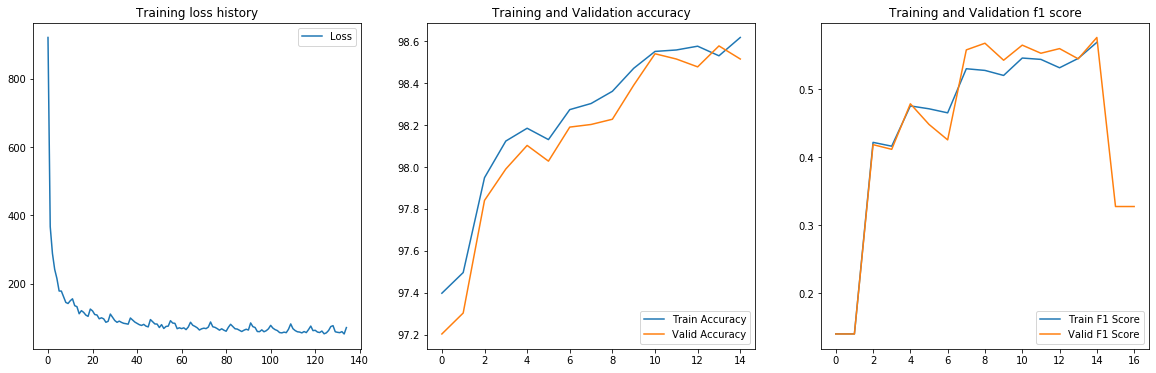

In [0]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].plot(loss_history, label='Loss')
axs[0].title.set_text("Training loss history")
axs[0].legend(loc="upper right")
axs[1].plot(train_acc, label='Train Accuracy')
axs[1].plot(val_acc, label='Valid Accuracy')
axs[1].title.set_text("Training and Validation accuracy")
axs[1].legend(loc="lower right")
axs[2].plot(train_f1_score, label='Train F1 Score')
axs[2].plot(val_f1_score, label='Valid F1 Score')
axs[2].title.set_text("Training and Validation f1 score")
axs[2].legend(loc="lower right")